In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, HuberRegressor
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV
from sklearn.cross_decomposition import PLSRegression, PLSCanonical

In [97]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [3]:
def plot_residual(y_true, y_pred, title='', cv_results=None):
    '''function to plot residual from a regression model'''
    label = None
    if cv_results is not None:
        if 'test_r2' in cv_results:
            r2_scores = cv_results['test_r2']
            estimate_r2 = r2_scores.mean()
            r2_SE = 2 * r2_scores.std() / np.sqrt(len(r2_scores))
            label1 = "$r^2:{:.2f} +/- {:.2f}$".format(estimate_r2, r2_SE)
            
        if 'test_neg_mean_squared_error' in cv_results:
            rmse_scores = np.sqrt(-cv_results['test_neg_mean_squared_error'])
            estimate_rmse = rmse_scores.mean()
            rmse_SE = 2 * rmse_scores.std() / np.sqrt(len(rmse_scores))

            label2 = "rmse:{:.2f} +/- {:.2f}".format(estimate_rmse, rmse_SE)
        label = label1 + '\n' + label2
        
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    y_min = min(y_pred.min(), y_true.min())
    y_max = max(y_pred.max(), y_true.max())

    # plot y_true vs. y_pred
    ax1.plot(y_pred, y_true, '.', alpha=.6, label=label)
    ax1.set_ylim(y_min, y_max)
    ax1.set_xlim(y_min, y_max)
    ax1.plot([y_min, y_max], [y_min, y_max], 'k--', alpha=.6)
    ax1.legend(loc='best')
    ax1.set(ylabel='y_true', xlabel='y_pred')

    # plot residual
    residual = y_true - y_pred
    ax2.plot(y_pred, residual, '.', alpha=.6)
    ax2.axhline(y=0, xmin=y_min, xmax=y_max,linestyle='--', color='k')
    ax2.set_xlim(y_min, y_max)
    ax2.set(xlabel='y_pred', ylabel='residual')
    
    fig.suptitle(title, fontsize=20)

In [ ]:
# data issues:
# -----------

# - no missing values

# 1. numeric features [4 columns]
#   - right skewness -> plan: yeo-johnson transformation
#   - on different scale
# 2. binary features [208 columns]
#   -
# 3. count features [16 columns]
#   - right skewness -> plan: yeo-johnson
#   - on different scale
# 4. target features
#   - distribution looks somewhat normal with left tail
# 5. collinear features
#   - remove highly correlated columns
#   - try dimensionality reduction using PCA
#   - try PLS model

# - add quadratic transform

In [4]:
X_train = pd.read_csv('datasets/solubility/solTrainX.csv', index_col=0)
X_test = pd.read_csv('datasets/solubility/solTestX.csv', index_col=0)
y_train = pd.read_csv('datasets/solubility/solTrainY.csv', index_col=0)['0'].values
y_test = pd.read_csv('datasets/solubility/solTestY.csv', index_col=0)['0'].values

In [5]:
num_cols = X_train.select_dtypes('float64').columns.tolist()
binary_cols = []           # start with FP...
count_cols = []       # start with Num...
for col in X_train.select_dtypes('int64').columns:
    if X_train[col].nunique() == 2:
        binary_cols.append(col)
    else:
        count_cols.append(col)

#### EDA

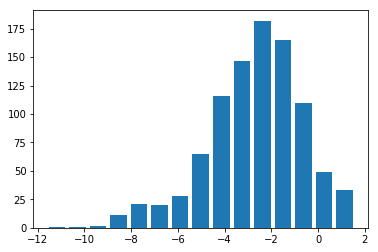

In [10]:
# target distribution
plt.hist(y_train, bins=15, rwidth=.8)
plt.show()

In [11]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 951 entries, 661 to 979
Columns: 228 entries, FP001 to SurfaceArea2
dtypes: float64(4), int64(224)
memory usage: 1.7 MB


#### float64 columns

In [39]:
num_cols = X_train.select_dtypes('float64').columns.tolist()
num_cols

['MolWeight', 'HydrophilicFactor', 'SurfaceArea1', 'SurfaceArea2']

In [12]:
# numeric features
X_train.select_dtypes('float64').describe()

,MolWeight,HydrophilicFactor,SurfaceArea1,SurfaceArea2
count,951.000000,951.000000,951.000000,951.000000
mean,201.653575,-0.020592,36.458938,40.234185
std,97.907971,1.126010,35.288510,38.123765
min,46.090000,-0.985000,0.000000,0.000000
25%,122.605000,-0.763000,9.230000,10.630000
50%,179.230000,-0.314000,29.100000,33.120000
75%,264.340000,0.313000,53.280000,60.660000
max,665.810000,13.483000,331.940000,331.940000


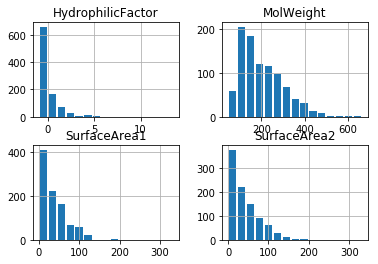

In [20]:
axs = X_train.select_dtypes('float64').hist(bins=15, rwidth=.8)

In [22]:
# skewness by each numeric column
X_train.select_dtypes('float64').skew()

MolWeight            0.989945
HydrophilicFactor    3.409164
SurfaceArea1         1.716853
SurfaceArea2         1.477373
dtype: float64

In [23]:
# numeric columns skewness summary
X_train.select_dtypes('float64').skew().describe()

count    4.000000
mean     1.898334
std      1.051653
min      0.989945
25%      1.355516
50%      1.597113
75%      2.139931
max      3.409164
dtype: float64

In [26]:
X_num = X_train.select_dtypes('float64')

yj_transformer = PowerTransformer(method='yeo-johnson')

X_num_jy = pd.DataFrame(yj_transformer.fit_transform(X_num), columns=X_num.columns)

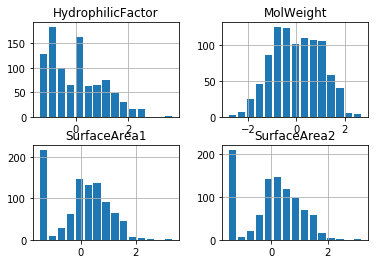

In [27]:
# histogram after yeo-johnson transformation
axs = X_num_jy.hist(bins=15, rwidth=.8)

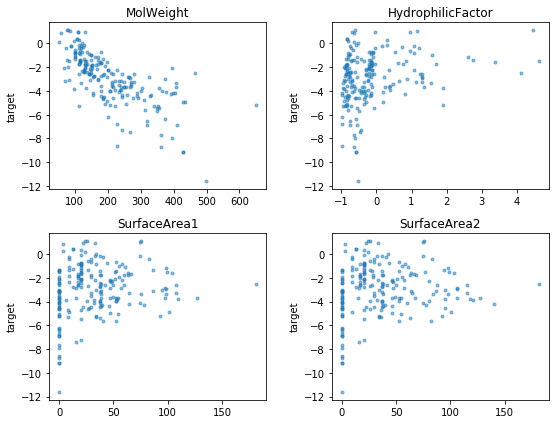

In [104]:
n = 200
idx = np.random.choice(np.arange(len(y_train)), size=n, replace=False)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

for col, ax in zip(num_cols, axs.flat):
    ax.scatter(X_num[col].iloc[idx], y_train[idx], marker='.', alpha=.5)
    ax.set_title(col)
    ax.set_ylabel('target')
fig.tight_layout()

#### int64 columns

In [14]:
# distribution of int64 columns by number of unique values
# 208 binary features
X_train.select_dtypes('int64').nunique().value_counts()

2     208
11      3
8       2
72      1
66      1
41      1
39      1
36      1
28      1
25      1
16      1
15      1
7       1
5       1
dtype: int64

In [6]:
binary_cols = []           # start with FP...
count_cols = []       # start with Num...
for col in X_train.select_dtypes('int64').columns:
    if X_train[col].nunique() == 2:
        binary_cols.append(col)
    else:
        count_cols.append(col)

In [7]:
# binary columns
X_train[binary_cols].head()

,FP001,FP002,FP003,FP004,FP005,FP006,FP007,FP008,FP009,FP010,...,FP199,FP200,FP201,FP202,FP203,FP204,FP205,FP206,FP207,FP208
661,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
662,0,1,0,1,1,1,1,1,0,0,...,0,0,0,1,0,0,0,0,0,0
663,1,1,1,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
665,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
668,0,0,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# summary of average value in each binary columns
# -----------------------------------------------
# the column that has lowest mean has only 3.8% 1-values
# the column that has highest mean has around 86% 1-values
# on average, a columns has about 19.4% 1-values
X_train[binary_cols].mean(axis=0).describe()

count    208.000000
mean       0.193748
std        0.155647
min        0.037855
25%        0.084122
50%        0.130915
75%        0.243954
max        0.860147
dtype: float64

In [105]:
len(binary_cols)

208

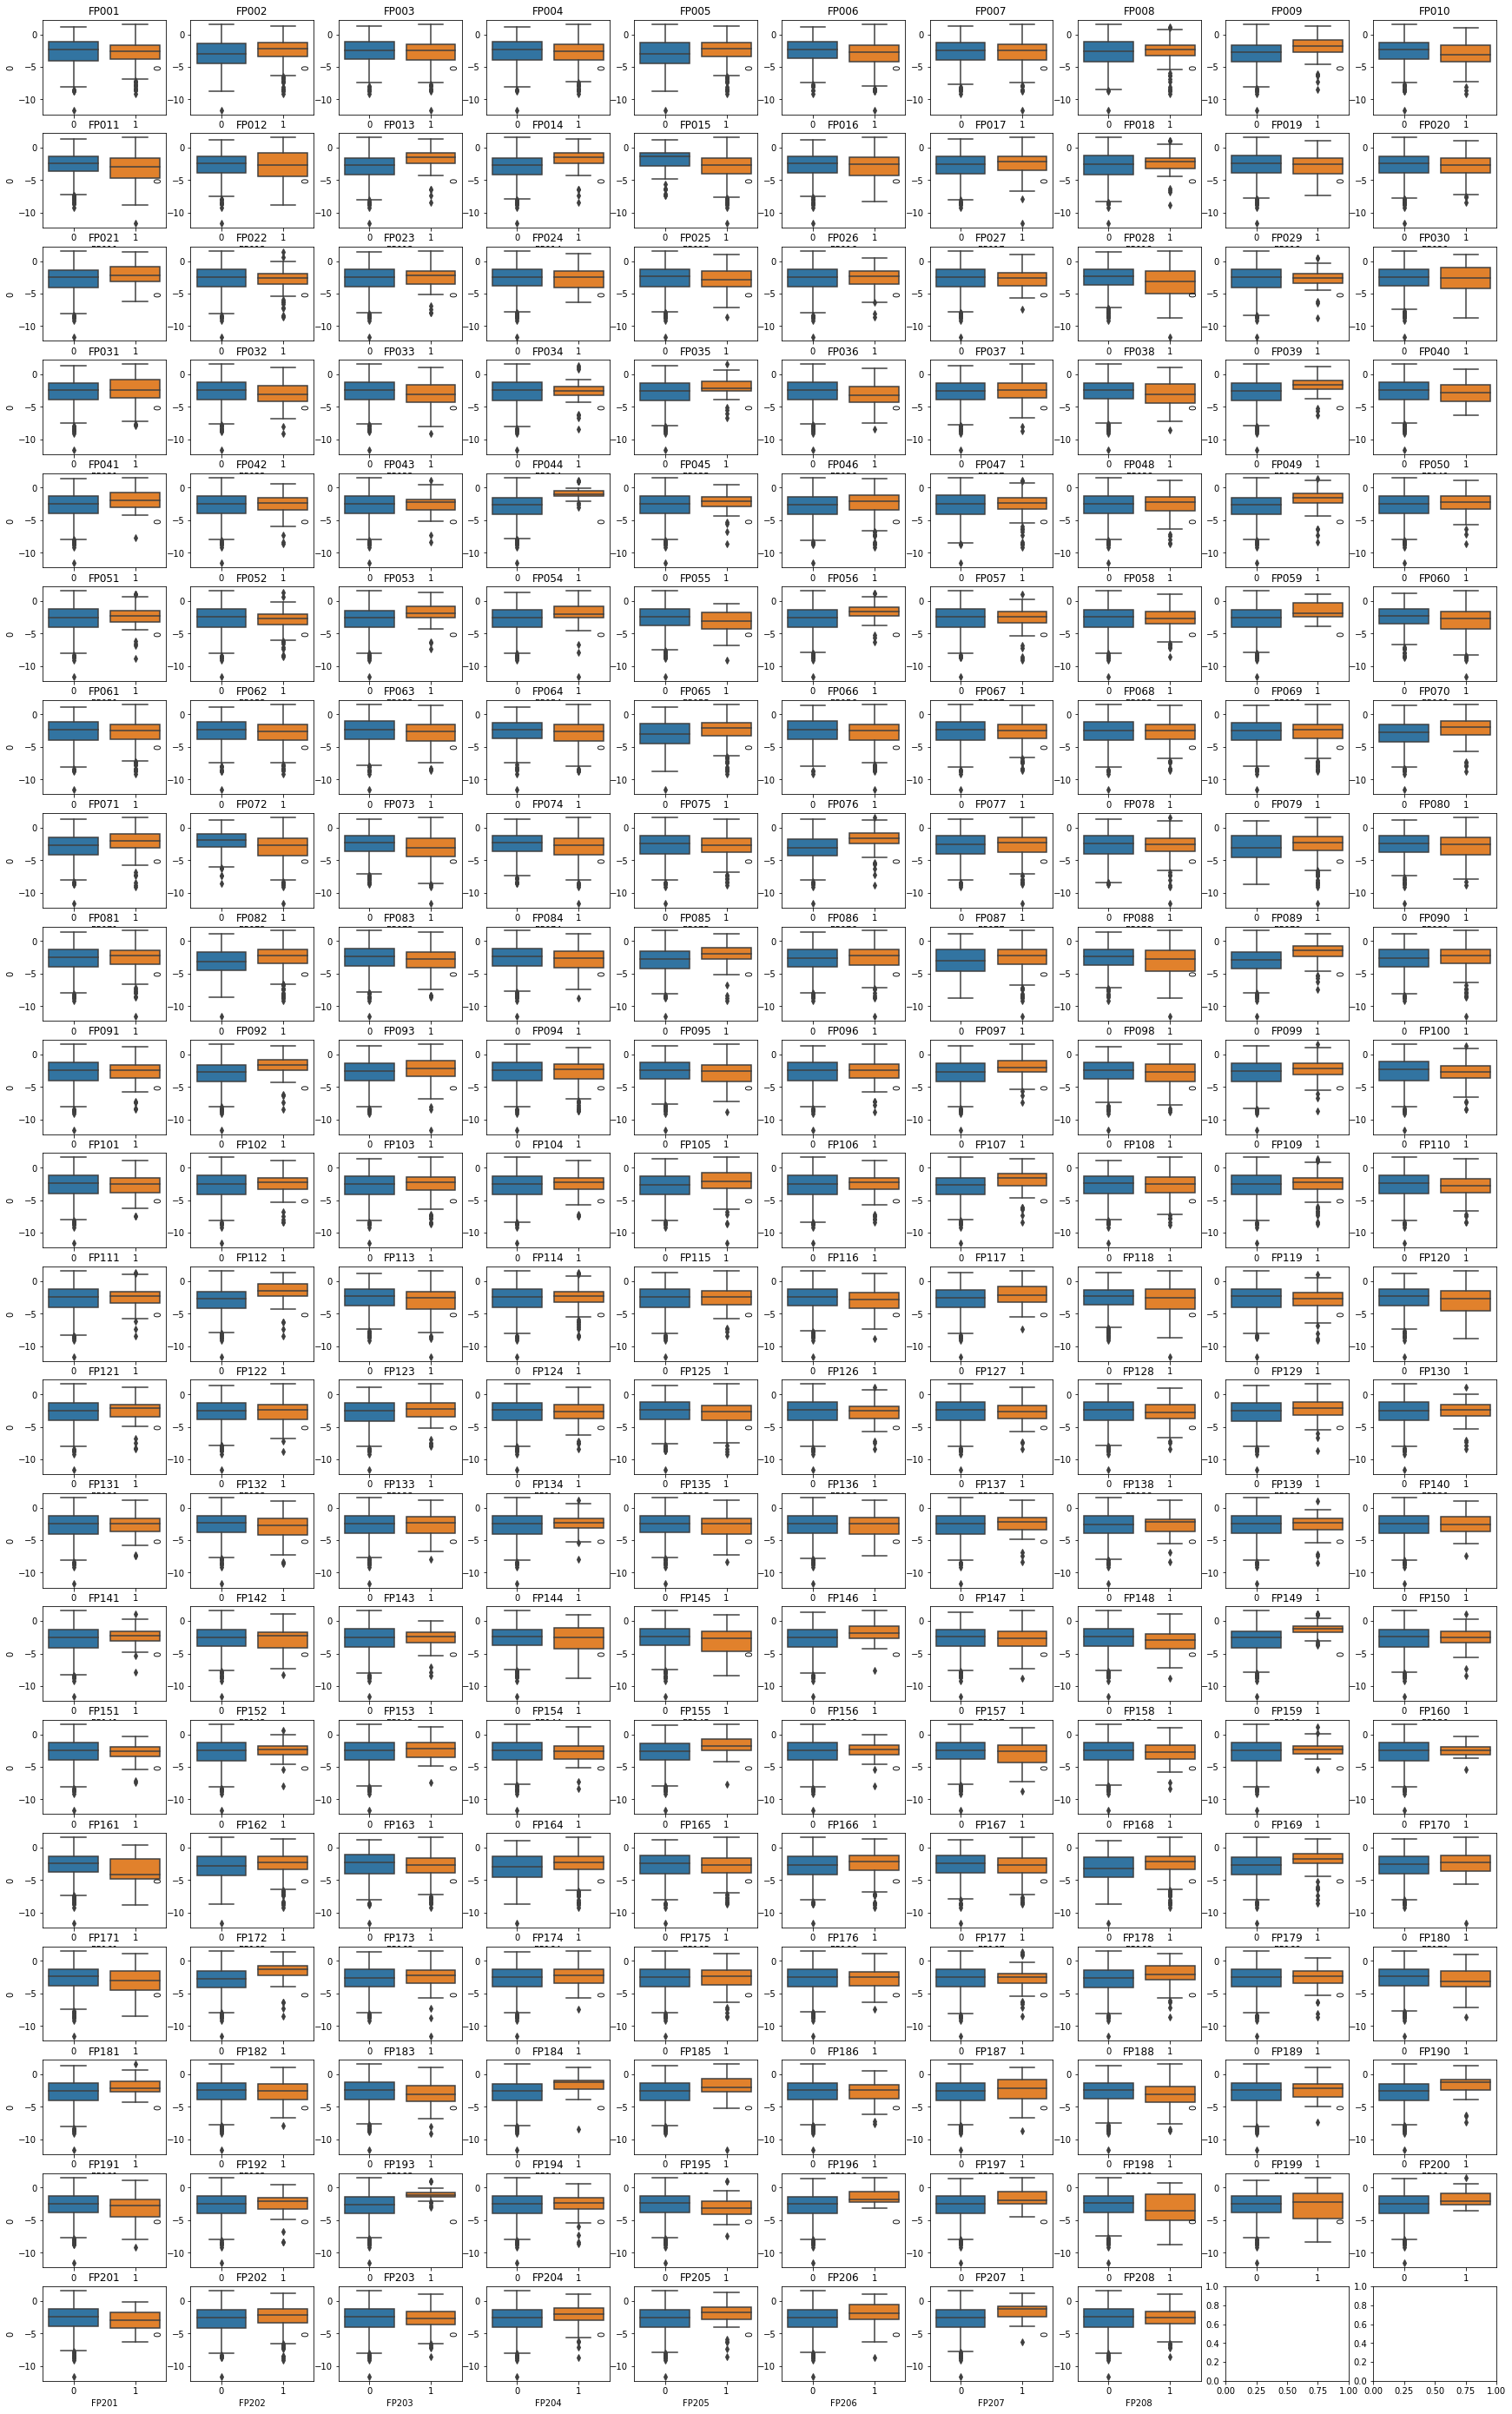

In [110]:
fig, axs = plt.subplots(nrows=21, ncols=10, figsize=(30, 50))

for col, ax in zip(binary_cols, axs.flat):
    sns.boxplot(X_train[col], y_train, ax=ax)
    ax.set_title(col)

In [31]:
# count columns
X_train[count_cols].head()

,NumAtoms,NumNonHAtoms,NumBonds,NumNonHBonds,NumMultBonds,NumRotBonds,NumDblBonds,NumAromaticBonds,NumHydrogen,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings
661,28,16,30,18,16,0,0,16,12,14,2,0,0,0,0,3
662,49,26,52,29,13,4,0,12,23,21,3,1,1,0,0,4
663,33,15,33,15,7,4,1,6,18,13,0,2,0,0,0,1
665,26,10,26,10,2,1,2,0,16,10,0,0,0,0,0,1
668,31,15,31,15,6,5,0,6,16,9,5,0,0,1,1,1


In [33]:
# each feature has different scale with std ranging from [0.5 - 13.47]
X_train[count_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
NumAtoms,951.0,25.506835,12.614015,5.0,17.0,22.0,31.0,94.0
NumNonHAtoms,951.0,13.160883,6.497156,2.0,8.0,12.0,17.0,47.0
NumBonds,951.0,25.908517,13.476882,4.0,17.0,23.0,31.5,97.0
NumNonHBonds,951.0,13.562566,7.566966,1.0,8.0,12.0,18.0,50.0
NumMultBonds,951.0,6.148265,5.171795,0.0,1.0,6.0,10.0,25.0
NumRotBonds,951.0,2.251314,2.408523,0.0,0.0,2.0,3.5,16.0
NumDblBonds,951.0,1.006309,1.210464,0.0,0.0,1.0,2.0,7.0
NumAromaticBonds,951.0,5.120925,5.260087,0.0,0.0,6.0,6.0,25.0
NumHydrogen,951.0,12.345952,7.318699,0.0,7.0,11.0,16.0,47.0
NumCarbon,951.0,9.892744,5.293597,1.0,6.0,9.0,12.0,33.0


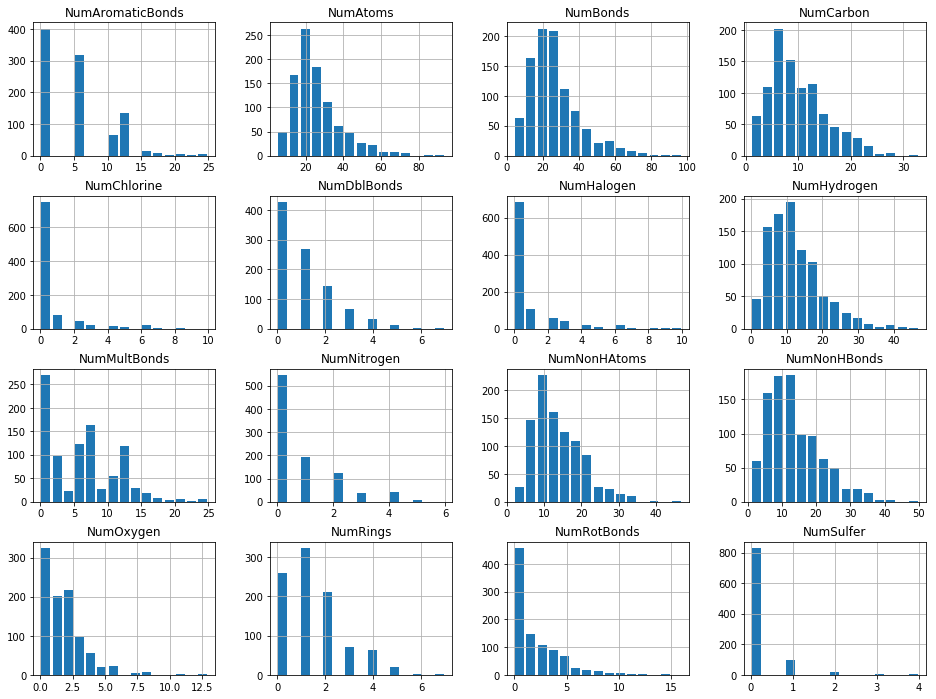

In [35]:
# most columns have right-skewed distribution
axs = X_train[count_cols].hist(bins=15, rwidth=.8, layout=(4,4), figsize=(16, 12))

In [93]:
X_train[count_cols].skew().describe()

count    16.000000
mean      1.586850
std       0.898435
min       0.671298
25%       0.988694
50%       1.361984
75%       1.628588
max       3.847603
dtype: float64

In [36]:
X_count = X_train[count_cols]
X_count_yj = pd.DataFrame(yj_transformer.fit_transform(X_count), 
                          columns=X_count.columns)

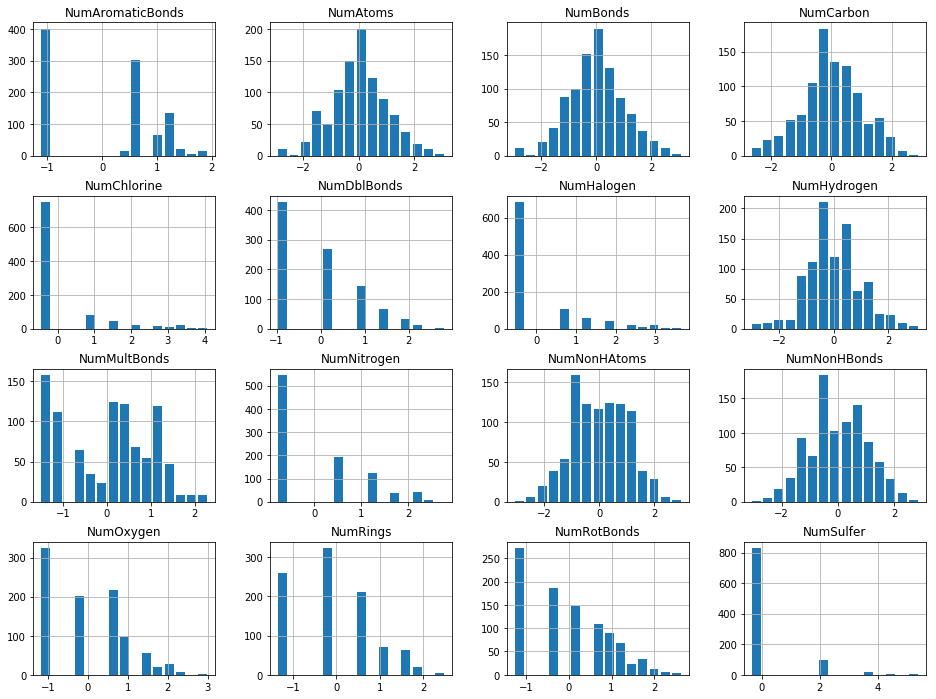

In [37]:
# distribution after yeo-johnson transformation
axs = X_count_yj.hist(bins=15, rwidth=.8, layout=(4,4), figsize=(16, 12))

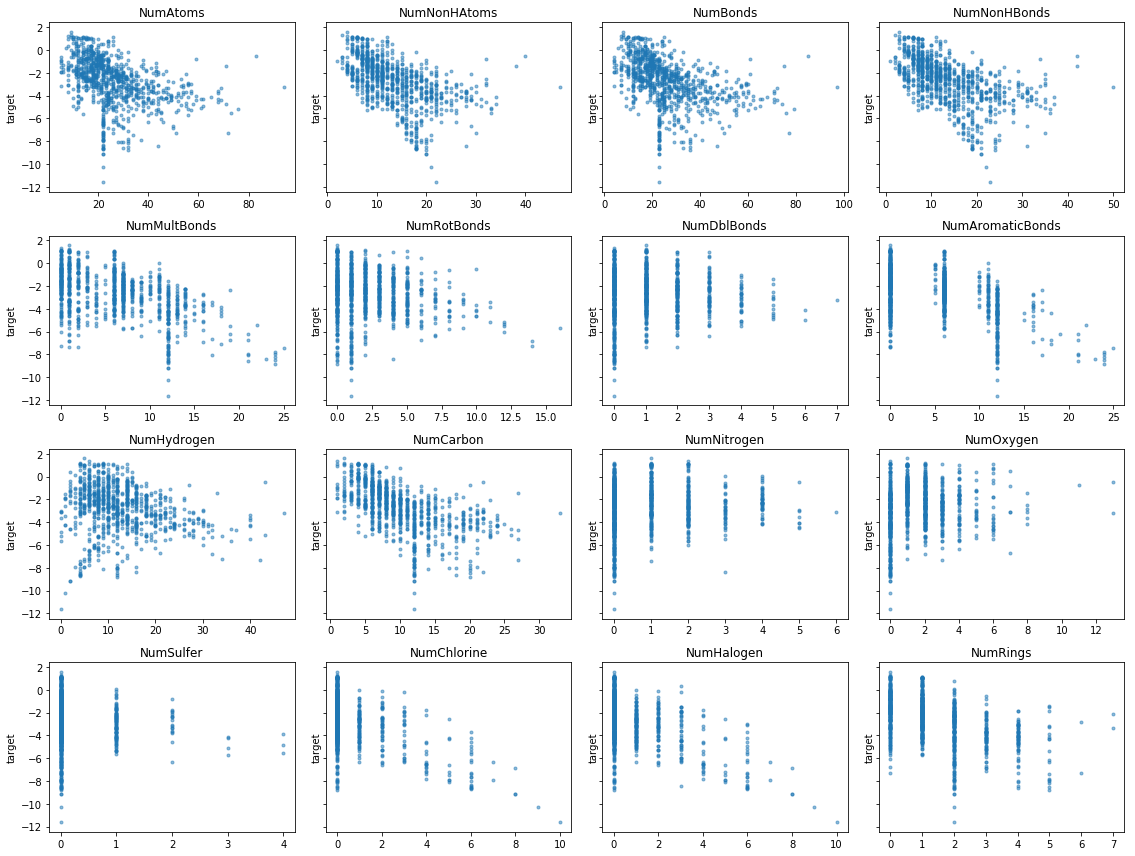

In [99]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(16, 12), sharey=True)

for col, ax in zip(count_cols, axs.flat):
    ax.scatter(X_count[col], y_train, marker='.', alpha=.5)
    ax.set_title(col)
    ax.set_ylabel('target')
    
fig.tight_layout()

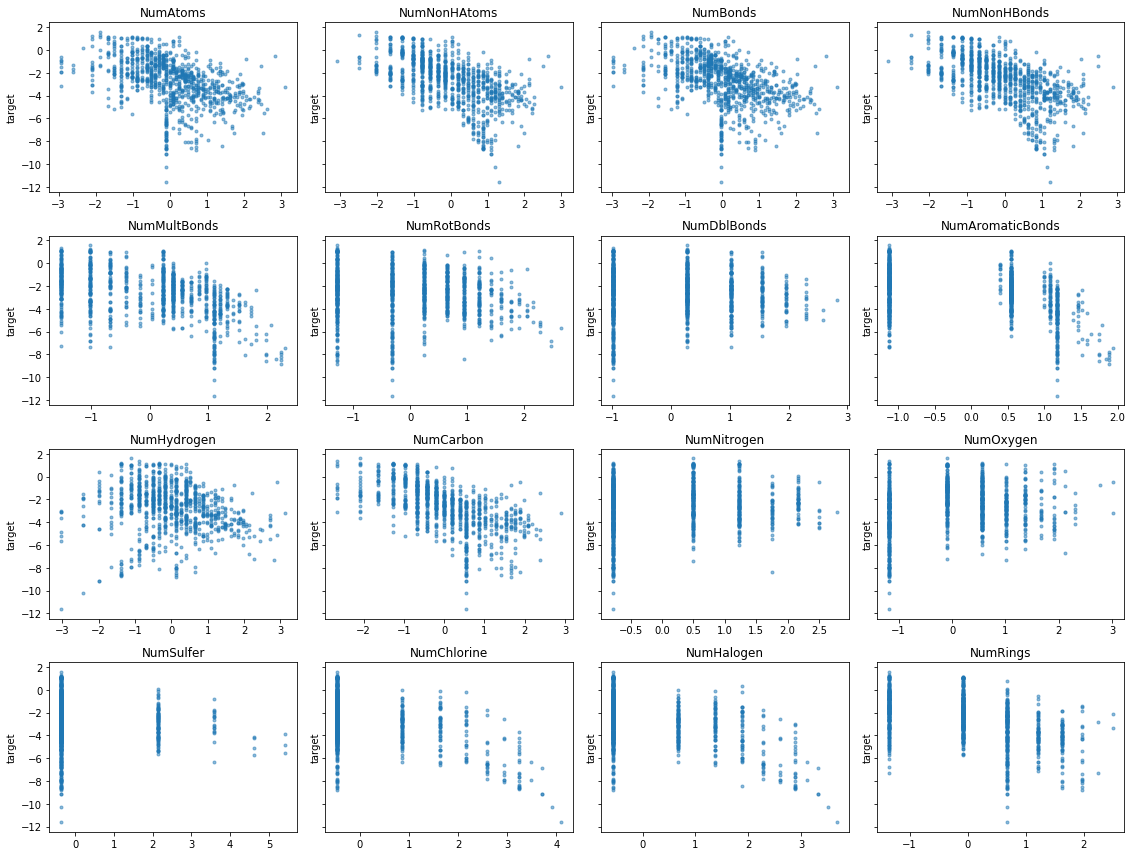

In [100]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(16, 12), sharey=True)

for col, ax in zip(count_cols, axs.flat):
    ax.scatter(X_count_yj[col], y_train, marker='.', alpha=.5)
    ax.set_title(col)
    ax.set_ylabel('target')
    
fig.tight_layout()

In [144]:
binary_cols

['FP001', 'FP002', 'FP003', 'FP004', 'FP005', 'FP006', 'FP007', 'FP008', 'FP009', 'FP010', 'FP011', 'FP012', 'FP013', 'FP014', 'FP015', 'FP016', 'FP017', 'FP018', 'FP019', 'FP020', 'FP021', 'FP022', 'FP023', 'FP024', 'FP025', 'FP026', 'FP027', 'FP028', 'FP029', 'FP030', 'FP031', 'FP032', 'FP033', 'FP034', 'FP035', 'FP036', 'FP037', 'FP038', 'FP039', 'FP040', 'FP041', 'FP042', 'FP043', 'FP044', 'FP045', 'FP046', 'FP047', 'FP048', 'FP049', 'FP050', 'FP051', 'FP052', 'FP053', 'FP054', 'FP055', 'FP056', 'FP057', 'FP058', 'FP059', 'FP060', 'FP061', 'FP062', 'FP063', 'FP064', 'FP065', 'FP066', 'FP067', 'FP068', 'FP069', 'FP070', 'FP071', 'FP072', 'FP073', 'FP074', 'FP075', 'FP076', 'FP077', 'FP078', 'FP079', 'FP080', 'FP081', 'FP082', 'FP083', 'FP084', 'FP085', 'FP086', 'FP087', 'FP088', 'FP089', 'FP090', 'FP091', 'FP092', 'FP093', 'FP094', 'FP095', 'FP096', 'FP097', 'FP098', 'FP099', 'FP100', 'FP101', 'FP102', 'FP103', 'FP104', 'FP105', 'FP106', 'FP107', 'FP108', 'FP109', 'FP110', 'FP111', 

#### Pre-processing Pipe

In [9]:
column_transformer = ColumnTransformer(transformers=[('col_num', PowerTransformer(standardize=False), 
                                                      num_cols + count_cols),
                                                     #('col_count', PowerTransformer(), count_cols)
                                                    ], 
                                       remainder='passthrough')

In [10]:
X_trans = pd.DataFrame(column_transformer.fit_transform(X_train), 
                       columns=num_cols + count_cols + binary_cols)

In [31]:
# remove highly correlated columns
corrs = (X_trans
             .assign(target=y_train)
             .corr())

threshold = .9

all_columns = corrs.columns.tolist()[:-1]

candidate_pairs = sorted([(all_columns[i], all_columns[j], abs(corrs.iloc[i,j]))
                        for i in range(len(all_columns)-1) 
                        for j in range(i+1, len(all_columns))
                           if abs(corrs.iloc[i,j]) >= threshold],
                         key=lambda x:x[-1], reverse=True)

to_remove = set()

for c1, c2, _ in candidate_pairs:
    if (c1 in to_remove) or (c2 in to_remove):
        continue
    if corrs[c1].abs().mean() > corrs[c2].abs().mean():
        to_remove.add(c1)
    else:
        to_remove.add(c2)
        
to_remove = list(to_remove)
print("Found {} highly correlated columns to remove".format(len(to_remove)))

Found 36 highly correlated columns to remove


In [32]:
# Train/Test Dataset: remove highly correlated feature
X_train_drop = X_train.drop(columns=to_remove)
X_test_drop = X_test.drop(columns=to_remove)

X_train_drop.shape, X_test_drop.shape

((951, 192), (316, 192))

In [35]:
num_cols_drop = [col for col in num_cols if col in X_train_drop.columns]
binary_cols_drop = [col for col in binary_cols if col in X_train_drop.columns]
count_cols_drop = [col for col in count_cols if col in X_train_drop.columns]

len(num_cols_drop) + len(binary_cols_drop) + len(count_cols_drop)

192

In [ ]:
column_transformer = ColumnTransformer([
    ('num_cols', PowerTransformer(standardize=False), num_cols+count_cols),
], remainder='passthrough')

column_transformer_drop = ColumnTransformer([
    ('num_cols', PowerTransformer(standardize=False), num_cols_drop+count_cols_drop),
], remainder='passthrough')

In [40]:
all_cols = num_cols + count_cols + binary_cols
all_cols_drop = num_cols_drop + count_cols_drop + binary_cols_drop

In [ ]:
X_train_trans = pd.DataFrame(column_transfromer.fit_transform(X_train), columns=all_cols)
X_test_trans = pd.DataFrame(column_transfromer.transform(X_test), columns=all_cols)

X_train_trans.shape, X_test_trans.shape

In [11]:
X_trans.head()

,MolWeight,HydrophilicFactor,SurfaceArea1,SurfaceArea2,NumAtoms,NumNonHAtoms,NumBonds,NumNonHBonds,NumMultBonds,NumRotBonds,...,FP199,FP200,FP201,FP202,FP203,FP204,FP205,FP206,FP207,FP208
0,5.346595,-1.222368,6.229447,6.368948,3.655938,3.046612,4.198218,3.716320,4.906306,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.907675,-0.438450,8.723133,10.940855,4.305132,3.586939,5.014303,4.457351,4.389584,1.609438,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.337127,-0.384450,7.453891,7.642334,3.843749,2.976738,4.335268,3.450606,3.086147,1.609438,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.924356,-1.420800,0.000000,0.000000,3.572032,2.549611,3.995911,2.894836,1.345742,0.693147,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.444365,-0.071380,8.856430,9.106865,3.771999,2.976738,4.245161,3.450606,2.811823,1.791760,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### PCA: visualize

In [13]:
pca = make_pipeline(StandardScaler(), PCA(n_components=None))
X_pca = pd.DataFrame(pca.fit_transform(X_trans), 
                     columns=["PC{}".format(i) for i in range(1, X_train.shape[1]+1)])
X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC219,PC220,PC221,PC222,PC223,PC224,PC225,PC226,PC227,PC228
0,1.250086,-5.402307,0.634035,4.731157,1.914011,-6.768123,1.282810,1.294526,-2.975821,-4.663931,...,-0.078115,0.023118,0.011821,-0.035965,-0.012675,-0.012853,-0.031137,0.043303,0.002513,-0.002618
1,8.389484,0.608186,-1.332126,7.579517,6.093659,0.516473,-2.624319,3.686697,-0.327545,4.204699,...,0.035574,0.000132,0.089590,0.110955,-0.141667,-0.069456,0.076225,-0.026110,0.003546,0.002647
2,-0.927593,1.595964,-1.539874,-5.304870,2.460151,-0.447819,0.663878,-0.686403,-0.939146,-0.515764,...,0.039507,-0.012495,-0.007353,0.016343,-0.031895,-0.003591,-0.031592,0.005661,-0.011007,-0.000342
3,-3.588863,4.646979,-3.112812,4.237818,-2.459967,-2.081019,3.156410,-4.006658,1.404454,-1.545146,...,0.100137,-0.027713,-0.015272,-0.022844,0.019112,-0.058878,0.023066,0.049059,0.008480,-0.001508
4,3.681145,-2.786914,4.479508,5.600731,-0.197327,2.716894,-3.481517,2.822161,-0.651033,0.218174,...,-0.176186,0.058350,-0.084194,0.009316,-0.106524,-0.024338,0.053757,-0.007670,-0.003652,0.000302


Text(0,0.5,'varaince explained')

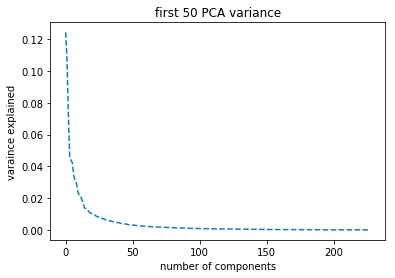

In [14]:
plt.title('first 50 PCA variance')
plt.plot(pca.steps[1][1].explained_variance_ratio_, '--')
plt.xlabel('number of components')
plt.ylabel('varaince explained')

Text(0,0.5,'varaince explained')

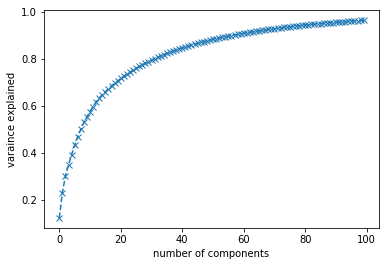

In [15]:
plt.plot(pca.steps[1][1].explained_variance_ratio_.cumsum()[:100], 'x--')
plt.xlabel('number of components')
plt.ylabel('varaince explained')

In [25]:
# correlation coeff of first 10 PC with the target
for col in ["PC{}".format(i) for i in range(1, 11)]:
    print(col, ':', round(X_pca[col].corr(pd.Series(y_train)), 2))

PC1 : -0.08
PC2 : 0.26
PC3 : 0.49
PC4 : -0.31
PC5 : -0.03
PC6 : -0.33
PC7 : -0.31
PC8 : -0.05
PC9 : -0.0
PC10 : 0.12


#### feature correlation

In [26]:
corrs = (X_trans
             .assign(target=y_train)
             .corr())

bin_corrs = (X_train[binary_cols]
             .assign(target=y_train)
             .corr())

num_corrs = (X_train[num_cols]
             .assign(target=y_train)
             .corr())

count_corrs = (X_train[count_cols]
             .assign(target=y_train)
             .corr())

In [28]:
target_corr = corrs['target'].abs().sort_values(ascending=False)

In [30]:
target_corr.head(15)

target          1.000000
MolWeight       0.658528
NumCarbon       0.606792
NumNonHBonds    0.585493
NumNonHAtoms    0.583231
FP076           0.537737
FP089           0.500865
NumRings        0.480815
FP044           0.476914
NumMultBonds    0.476387
NumChlorine     0.470687
NumHalogen      0.468069
NumBonds        0.458841
NumAtoms        0.435500
FP172           0.431877
Name: target, dtype: float64

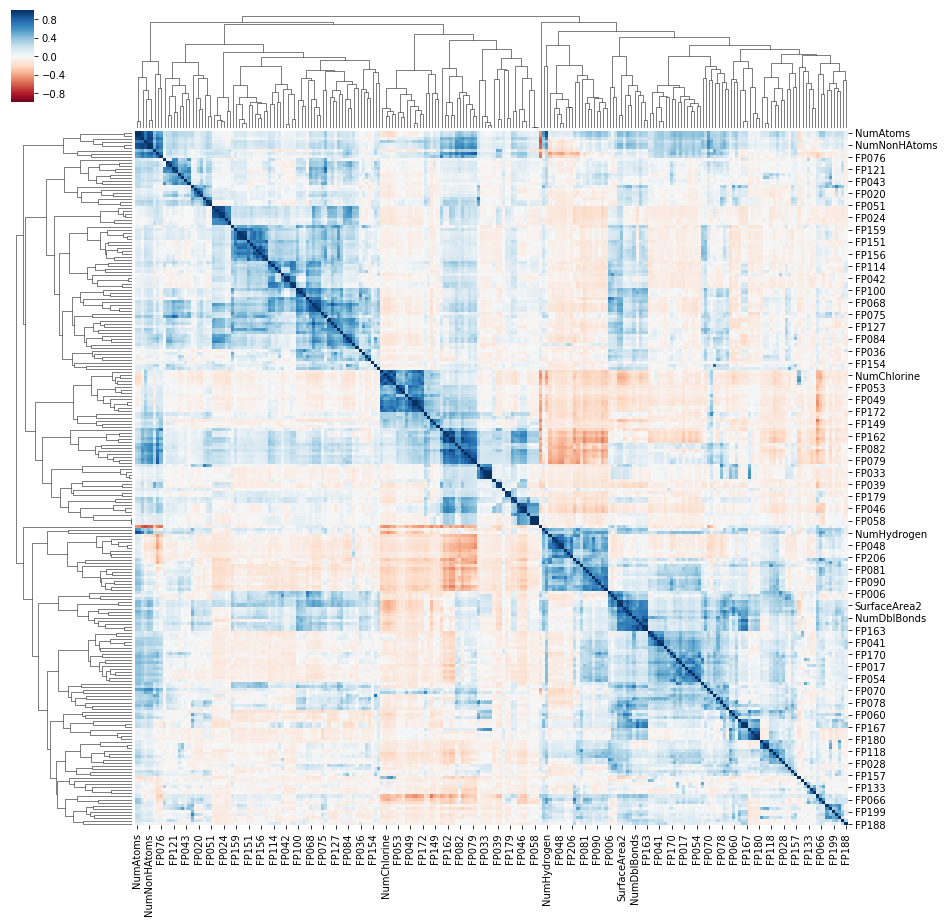

In [128]:
sns.clustermap(corrs, annot=False, vmin=-1.,vmax=1., cmap=plt.cm.RdBu, figsize=(15, 15))

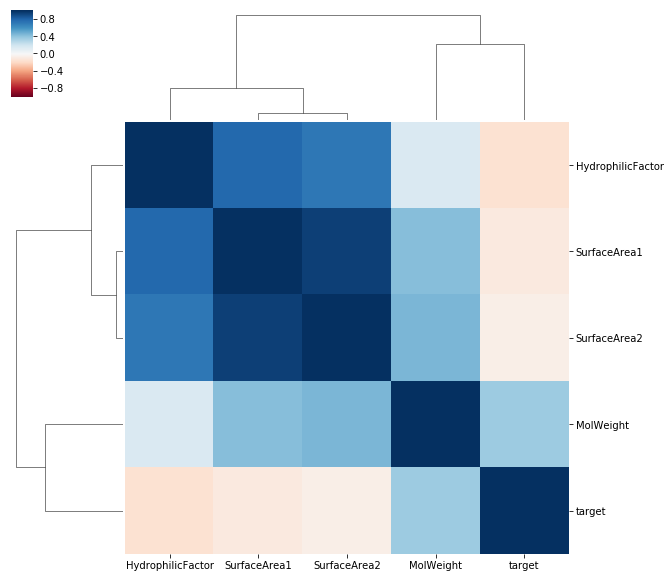

In [115]:
sns.clustermap(num_corrs, annot=False, vmin=-1.,vmax=1., cmap=plt.cm.RdBu)

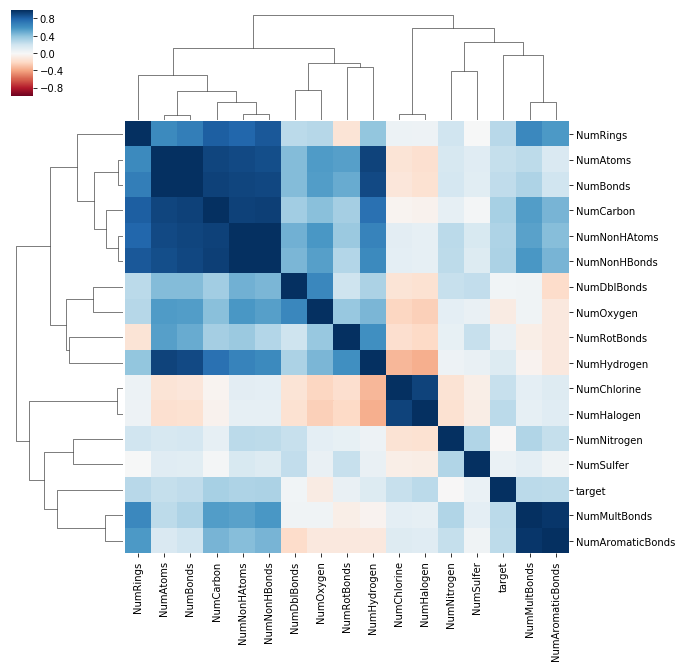

In [117]:
sns.clustermap(count_corrs, annot=False, vmin=-1.,vmax=1., cmap=plt.cm.RdBu, figsize=(10, 10))

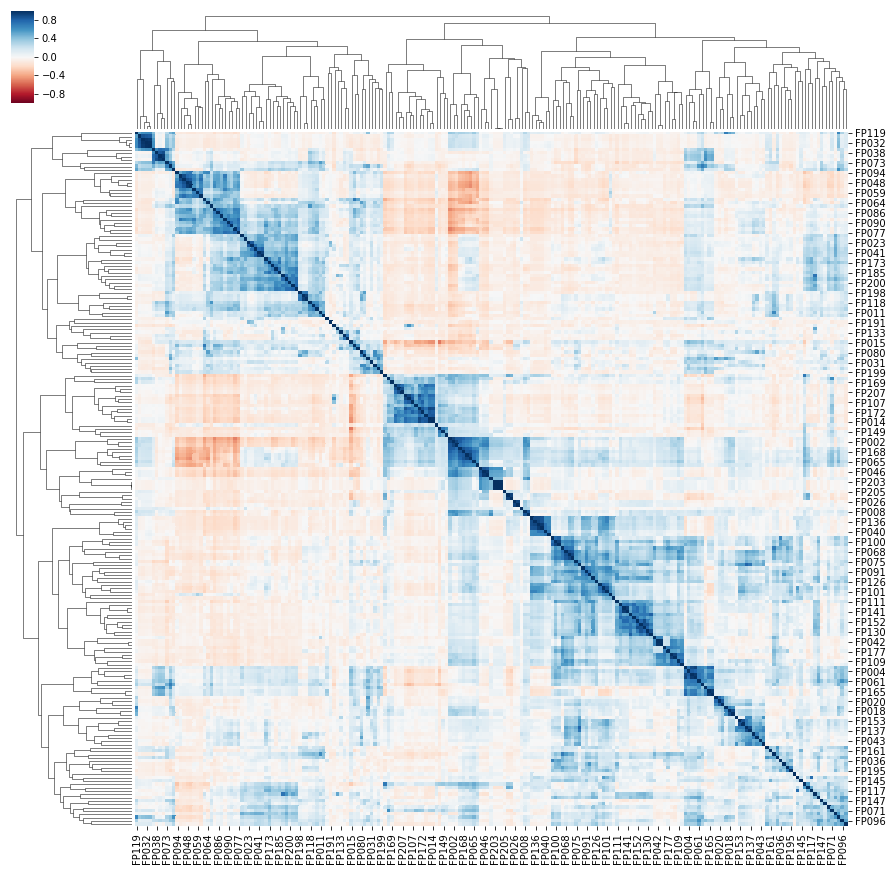

In [118]:
sns.clustermap(bin_corrs, annot=False, vmin=-1.,vmax=1., cmap=plt.cm.RdBu, figsize=(15, 15))

In [134]:
corrs.shape

(229, 229)

In [ ]:
# remove highly correlated columns
def get_collinear_columns(corr, threshold=.9, verbose=True):
    all_columns = corr.columns.tolist()[:-1]

    candidate_pairs = sorted([(all_columns[i], all_columns[j], abs(corr.iloc[i,j]))
                            for i in range(len(all_columns)-1) 
                            for j in range(i+1, len(all_columns))
                               if abs(corr.iloc[i,j]) >= threshold],
                             key=lambda x:x[-1], reverse=True)

    to_remove = set()

    for c1, c2, _ in candidate_pairs:
        if (c1 in to_remove) or (c2 in to_remove):
            continue
        if corr[c1].abs().mean() > corr[c2].abs().mean():
            to_remove.add(c1)
        else:
            to_remove.add(c2)

    to_remove = list(to_remove)
    if verbose:
        print("Found {} highly correlated columns to remove".format(len(to_remove)))
    return to_remove

In [269]:
to_remove

['FP100', 'FP183', 'FP208', 'FP041', 'NumNonHAtoms', 'FP013', 'FP087', 'FP001', 'FP025', 'FP166', 'SurfaceArea2', 'NumBonds', 'FP167', 'FP030', 'FP067', 'FP026', 'NumNitrogen', 'FP163', 'FP019', 'NumAtoms', 'FP009', 'FP005', 'FP002', 'FP175', 'NumChlorine', 'NumAromaticBonds', 'FP014', 'FP056', 'FP022', 'FP018', 'FP042', 'FP134', 'FP058', 'FP033', 'NumNonHBonds', 'FP141']

#### Modeling

In [39]:
# setting resampling methods
# --------------------------
score_metrics = ['neg_mean_squared_error', 'r2']
repeat_cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
k10 = KFold(n_splits=10, random_state=123)

In [42]:
X_trans_full = pd.DataFrame(column_transformer.fit_transform(X_train), columns=all_cols)

In [44]:
X_trans_full.head()

,MolWeight,HydrophilicFactor,SurfaceArea1,SurfaceArea2,NumAtoms,NumNonHAtoms,NumBonds,NumNonHBonds,NumMultBonds,NumRotBonds,...,FP199,FP200,FP201,FP202,FP203,FP204,FP205,FP206,FP207,FP208
0,0.303021,-1.108163,0.054456,-0.033074,0.414490,0.618505,0.509713,0.740777,1.525830,-1.288546,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.477283,-0.137189,0.684493,1.049235,1.634618,1.662549,1.679455,1.690831,1.205733,0.951917,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.283205,-0.070304,0.363815,0.268375,0.767472,0.483492,0.706155,0.400112,0.398286,0.951917,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.580667,-1.353945,-1.519432,-1.540797,0.256793,-0.341823,0.219734,-0.312425,-0.679854,-0.323631,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.507639,0.317470,0.718171,0.615074,0.632620,0.483492,0.576998,0.400112,0.228348,1.205723,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Linear Regression

linreg_pipe_full = make_pipeline(column_transformer, 
                                 HuberRegressor())

linreg_pipe_drop = make_pipeline(column_transformer_drop, HuberRegressor())

results_full = cross_validate(linreg_pipe_full, X_train, y_train, return_train_score=True,
                         scoring=score_metrics, cv=k10)

y_pred_full = cross_val_predict(linreg_pipe_full, X_train, y_train, cv=k10)

results_drop = cross_validate(linreg_pipe_drop, X_train, y_train, return_train_score=True,
                            scoring=score_metrics, cv=k10)
y_pred_drop = cross_val_predict(linreg_pipe_drop, X_train, y_train, cv=k10)

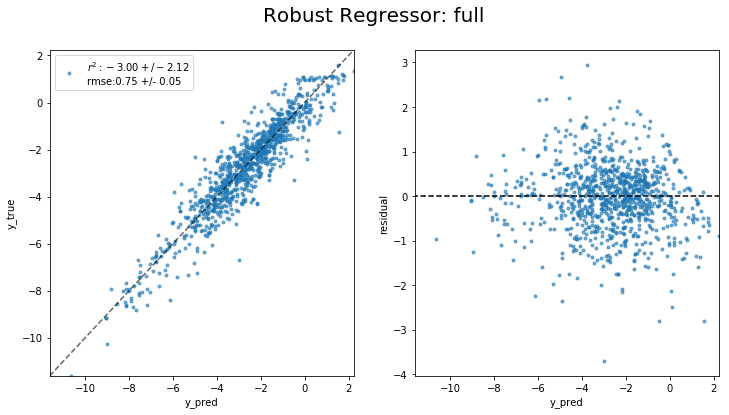

In [50]:
plot_residual(y_train, y_pred_full, title='Robust Regressor: full', cv_results=results_full)

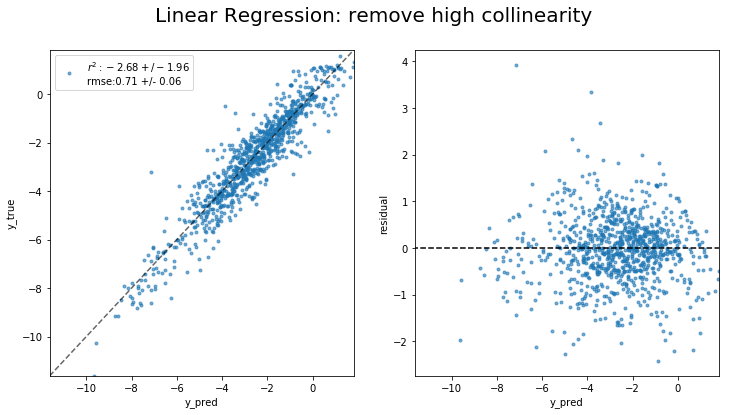

In [51]:
plot_residual(y_train, y_pred_drop, title='Linear Regression: remove high collinearity', 
              cv_results=results_drop)

In [52]:
# Partial least Squares
pls_estimator = make_pipeline(column_transformer,
                              #StandardScaler(),
                              PLSRegression(scale=False))

pls_params = {'plsregression__n_components': range(1, 30)}

pls_grid = GridSearchCV(pls_estimator, pls_params, cv=k10, scoring=score_metrics, refit=score_metrics[0],
                        verbose=1, n_jobs=4, return_train_score=False)

In [53]:
pls_grid.fit(X_train, y_train)

Fitting 10 folds for each of 29 candidates, totalling 290 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   35.2s
[Parallel(n_jobs=4)]: Done 290 out of 290 | elapsed:   54.6s finished
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_cols', PowerTransformer(copy=True, method='yeo-johnson', standardize=True), ['MolWeight', 'HydrophilicFactor', 'SurfaceArea1', 'S..., ('plsregression', PLSRegression(copy=True, max_iter=500, n_components=2, scale=False, tol=1e-06))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'plsregression__n_components': range(1, 30)},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=False, scoring=['neg_mean_squared_error', 'r2'],
       verbose=1)

In [54]:
np.sqrt(-pls_grid.best_score_), pls_grid.best_params_

(0.7091555147050079, {'plsregression__n_components': 19})

In [55]:
pls_grid_cv_results = pls_grid.cv_results_

In [56]:
pls_cv_results = cross_validate(pls_grid.best_estimator_, X_train, y_train, 
                                scoring=score_metrics, cv=k10)
pls_pred = cross_val_predict(pls_grid.best_estimator_, X_train, y_train, cv=k10)

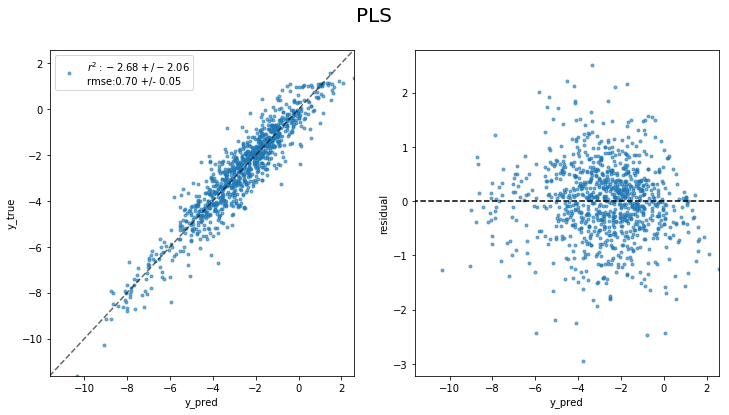

In [57]:
plot_residual(y_train, pls_pred.ravel(), title='PLS', cv_results=pls_cv_results)

In [58]:
# PCR
pcr_estimator = make_pipeline(column_transformer, 
                              #StandardScaler(), 
                              PCA(), 
                              LinearRegression())

pcr_params = {'pca__n_components':range(1, 80, 2)}

pcr_grid = GridSearchCV(pcr_estimator, pcr_params, refit=score_metrics[0], n_jobs=8, 
                        scoring=score_metrics, return_train_score=False, cv=k10, verbose=1)

In [59]:
pcr_grid.fit(X_train, y_train)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   20.3s
[Parallel(n_jobs=8)]: Done 400 out of 400 | elapsed:   42.0s finished
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_cols', PowerTransformer(copy=True, method='yeo-johnson', standardize=True), ['MolWeight', 'HydrophilicFactor', 'SurfaceArea1', 'S...ression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid={'pca__n_components': range(1, 80, 2)},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=False, scoring=['neg_mean_squared_error', 'r2'],
       verbose=1)

In [60]:
print("best n-components: {}, val-auc:{:.4f}".format(pcr_grid.best_params_['pca__n_components'],
                                                     np.sqrt(-pcr_grid.best_score_)))

best n-components: 65, val-auc:0.7343


In [61]:
pcr_grid_cv_results = pcr_grid.cv_results_

In [62]:
rmse_se = pcr_grid_cv_results['std_test_neg_mean_squared_error'].std() / len(pcr_grid_cv_results['std_test_neg_mean_squared_error'])
rmse_se

0.016072939039442017

In [63]:
rmse_scores = np.sqrt(-pcr_grid.cv_results_['mean_test_neg_mean_squared_error'])
n_comp = pcr_grid.cv_results_['param_pca__n_components'].data.astype(int)

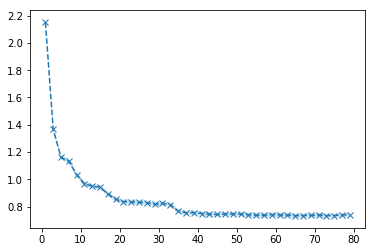

In [64]:
plt.plot(n_comp, rmse_scores, 'x--')
plt.fill_between(n_comp, rmse_scores-rmse_se, 
                 rmse_scores+rmse_se, alpha=.2)


In [65]:
results = cross_validate(pcr_grid.best_estimator_, X_train, y_train, scoring=score_metrics,
                         cv=repeat_cv, return_train_score=False, verbose=1, n_jobs=4)

y_pred = cross_val_predict(pcr_grid.best_estimator_, X_train, y_train, cv=k10, verbose=1)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.4s finished


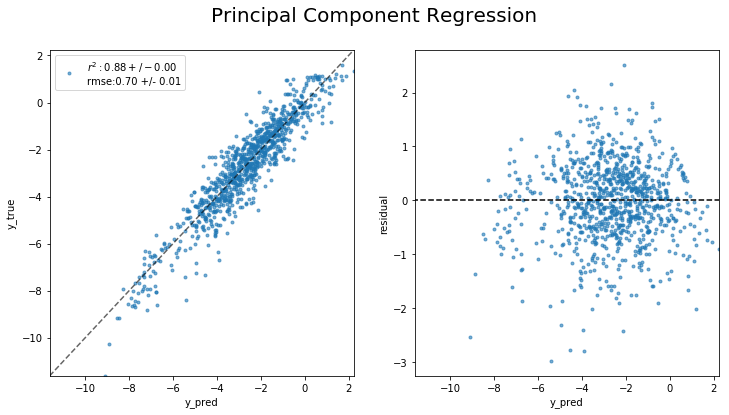

In [66]:
plot_residual(y_train, y_pred, title='Principal Component Regression', cv_results=results)

In [67]:
n_40 = pcr_grid.best_estimator_.set_params(pca__n_components=40)
results = cross_validate(n_40, X_train, y_train, scoring=score_metrics,
                         cv=repeat_cv, return_train_score=False, verbose=1, n_jobs=4)

y_pred = cross_val_predict(n_40, X_train, y_train, cv=k10, verbose=1)


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    8.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.0s finished


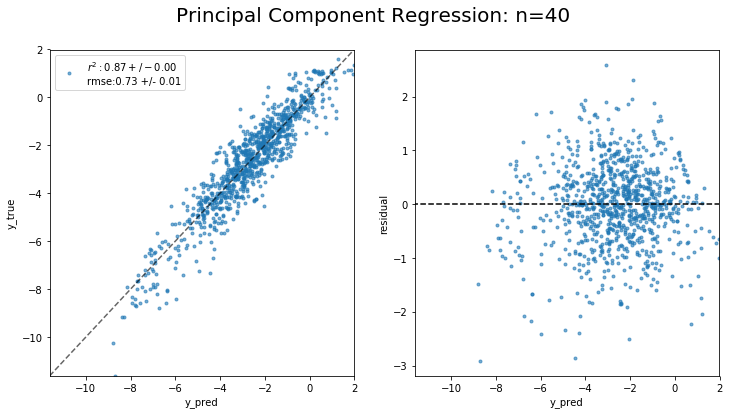

In [68]:
plot_residual(y_train, y_pred, title='Principal Component Regression: n=40', cv_results=results)

#### Penalized Regression Models

In [70]:
ridge_alphas = np.logspace(np.log10(.01), np.log10(1), base=10, num=10)
ridge_alphas

array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])

In [72]:
ridge_estimator_full = make_pipeline(column_transformer_drop, 
                                #StandardScaler(), 
                                Ridge())

ridge_params = {'ridge__alpha': ridge_alphas}
ridge_grid_full = GridSearchCV(ridge_estimator_full, param_grid=ridge_params, cv=k10, verbose=1,
                          scoring=score_metrics[0], return_train_score=False, n_jobs=4)
ridge_grid_full.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    9.6s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_cols', PowerTransformer(copy=True, method='yeo-johnson', standardize=True), ['MolWeight', 'HydrophilicFactor', 'SurfaceArea1', 'N...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'ridge__alpha': array([0.01   , 0.01668, 0.02783, 0.04642, 0.07743, 0.12915, 0.21544,
       0.35938, 0.59948, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=1)

In [73]:
np.sqrt(-ridge_grid_full.best_score_), ridge_grid_full.best_params_

(0.7048814048653461, {'ridge__alpha': 1.0})

In [74]:
ridge_cv = cross_validate(ridge_grid_full.best_estimator_, X_train, y_train, return_estimator=True, 
                          scoring=score_metrics, cv=k10, verbose=1, return_train_score=False)


best_ridge = ridge_cv['estimator'][0]
y_pred = best_ridge.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.2s finished


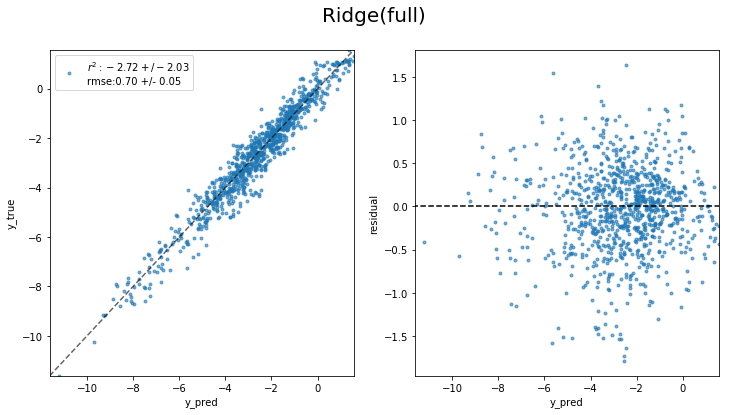

In [75]:
plot_residual(y_train, y_pred, title='Ridge(full)', cv_results=ridge_cv)

In [76]:
ridge_estimator = make_pipeline(column_transformer, 
                                #StandardScaler(), 
                                Ridge())
ridge_params = {
        'ridge__alpha':ridge_alphas,
        'ridge__normalize':[True, False]
}
ridge_grid = GridSearchCV(ridge_estimator, param_grid=ridge_params, cv=k10, verbose=1,
                          scoring=score_metrics[0], return_train_score=False, n_jobs=4)

In [77]:
ridge_grid.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   23.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:   24.7s finished
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_cols', PowerTransformer(copy=True, method='yeo-johnson', standardize=True), ['MolWeight', 'HydrophilicFactor', 'SurfaceArea1', 'S...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'ridge__normalize': [True, False], 'ridge__alpha': array([0.01   , 0.01668, 0.02783, 0.04642, 0.07743, 0.12915, 0.21544,
       0.35938, 0.59948, 1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='neg_mean_squared_error', verbose=1)

In [78]:
ridge_grid.best_params_, np.sqrt(-ridge_grid.best_score_)

({'ridge__alpha': 1.0, 'ridge__normalize': False}, 0.7060560662172278)

In [79]:
ridge_cv['test_neg_mean_squared_error']

array([-0.63436994, -0.44809803, -0.49407264, -0.38715276, -0.70834021,
       -0.32364719, -0.63044042, -0.49742377, -0.47693447, -0.36665102])

In [80]:
ridge_cv = cross_validate(ridge_grid.best_estimator_, X_train, y_train, return_estimator=True, 
                          scoring=score_metrics, cv=k10, verbose=1, return_train_score=False)

best_ridge = ridge_cv['estimator'][0]
y_pred = best_ridge.predict(X_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.1s finished


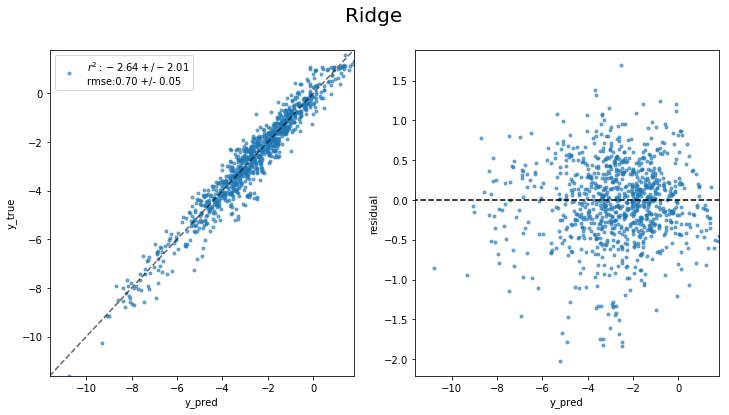

In [81]:
plot_residual(y_train, y_pred, title='Ridge', cv_results=ridge_cv)

In [125]:
# Neural Network


neural_estimator = make_pipeline(column_transformer_drop, 
                                 MLPRegressor(max_iter=500, early_stopping=True, random_state=42))

neural_params = {
    'mlpregressor__hidden_layer_sizes': list(range(1,13)),
    'mlpregressor__alpha': [.1,.5, 1.],#np.logspace(np.log10(.001), np.log10(.1), base=10, num=10)
}

neural_grid = GridSearchCV(neural_estimator, neural_params, scoring=score_metrics[0], 
                           cv=k10, verbose=1, n_jobs=4, return_train_score=True)

In [126]:
neural_grid.fit(X_train_drop, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   36.5s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:  4.9min finished
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num_cols', PowerTransformer(copy=True, method='yeo-johnson', standardize=True), ['MolWeight', 'HydrophilicFactor', 'SurfaceArea1', 'N...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'mlpregressor__hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'mlpregressor__alpha': [0.1, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score=True, scoring=['neg_mean_squared_error', 'r2'],
       verbose=1)

In [127]:
np.sqrt(-neural_grid.best_score_), neural_grid.best_params_

(0.6995189163645121,
 {'mlpregressor__alpha': 1.0, 'mlpregressor__hidden_layer_sizes': 9})

In [105]:
np.sqrt(-neural_grid.best_score_), neural_grid.best_params_

(0.7198116303938012,
 {'mlpregressor__alpha': 1.0, 'mlpregressor__hidden_layer_sizes': 9})

In [128]:
neural_cv = pd.DataFrame(neural_grid.cv_results_)
neural_cv.head()

,mean_fit_time,mean_score_time,mean_test_neg_mean_squared_error,mean_test_r2,mean_train_neg_mean_squared_error,mean_train_r2,param_mlpregressor__alpha,param_mlpregressor__hidden_layer_sizes,params,rank_test_neg_mean_squared_error,...,split9_test_neg_mean_squared_error,split9_test_r2,split9_train_neg_mean_squared_error,split9_train_r2,std_fit_time,std_score_time,std_test_neg_mean_squared_error,std_test_r2,std_train_neg_mean_squared_error,std_train_r2
0,3.860074,0.240153,-3.593966,-8.759790,-3.375926,0.188251,0.1,1,"{'mlpregressor__hidden_layer_sizes': 1, 'mlpre...",36,...,-0.535531,0.066136,-3.750060,0.056457,0.105845,0.006856,5.152968,12.419030,0.537948,0.088100
1,3.380811,0.236828,-0.609852,-2.898889,-0.324739,0.920170,0.1,2,"{'mlpregressor__hidden_layer_sizes': 2, 'mlpre...",28,...,-0.386158,0.326615,-0.330853,0.916755,0.396532,0.006930,0.261876,3.326468,0.024253,0.015129
2,2.863099,0.240976,-0.608326,-2.809103,-0.353337,0.913955,0.1,3,"{'mlpregressor__hidden_layer_sizes': 3, 'mlpre...",27,...,-0.437730,0.236683,-0.390857,0.901658,0.460809,0.011655,0.226532,3.195865,0.061130,0.016030
3,1.517819,0.240194,-0.553654,-2.638968,-0.294772,0.928247,0.1,4,"{'mlpregressor__hidden_layer_sizes': 4, 'mlpre...",13,...,-0.482173,0.159183,-0.422180,0.893776,0.366148,0.009068,0.158388,2.997054,0.077674,0.019459
4,2.900569,0.240178,-0.577297,-2.961665,-0.262813,0.935499,0.1,5,"{'mlpregressor__hidden_layer_sizes': 5, 'mlpre...",22,...,-0.344329,0.399556,-0.234220,0.941068,0.368517,0.005352,0.203171,3.484859,0.027906,0.011948


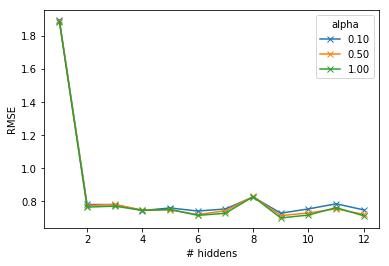

In [129]:
for alpha in neural_params['mlpregressor__alpha']:

    mse = -neural_cv.query('param_mlpregressor__alpha=={:f}'.format(alpha))['mean_test_neg_mean_squared_error'].values
    n_hiddens = (neural_cv.query('param_mlpregressor__alpha==1.0')
                            ['param_mlpregressor__hidden_layer_sizes']
                             .values
                             .astype(int)
            )

    plt.plot(n_hiddens, np.sqrt(mse), 'x-', label="{:.2f}".format(alpha))
    plt.xlabel('# hiddens')
    plt.ylabel('RMSE')
plt.legend(loc='best', title='alpha')

In [130]:
neural_cv = cross_validate(neural_grid.best_estimator_, X_train_drop, y_train, return_estimator=True, 
                          scoring=score_metrics, cv=k10, verbose=1, return_train_score=False)


best_neural = neural_cv['estimator'][0]
y_pred = best_neural.predict(X_train_drop)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   29.9s finished


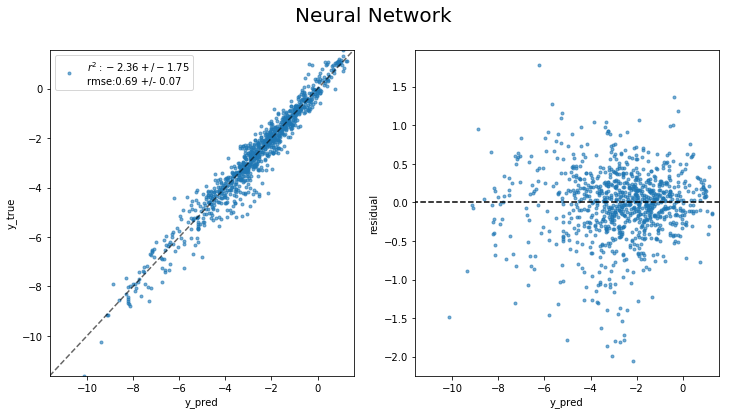

In [131]:
plot_residual(y_train, y_pred, title='Neural Network', cv_results=neural_cv)

#### SVM

In [136]:
svr_estimator = make_pipeline(column_transformer_drop,
                              StandardScaler(),
                              SVR(gamma='scale'))

svr_params = {
    'svr__kernel': ['linear', 'rbf'],
    'svr__C': 2**np.arange(-2, 12, dtype=float)
}

svr_grid = GridSearchCV(svr_estimator, svr_params, scoring=score_metrics[0], n_jobs=4, 
                        cv=k10,verbose=1, return_train_score=False)

In [137]:
svr_grid.fit(X_train_drop, y_train)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   12.5s


KeyboardInterrupt: 

In [ ]:
# KNN
